In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
from scipy.optimize import minimize

In [ ]:
def emaCompare(stock_symbols):
  stock_selected = []
  for i in stock_symbols:
    stock = yf.Ticker(i)
    stock_data = stock.history(period = '5y')
    stock_data['EMA_15'] = stock_data['Close'].ewm(span=15, adjust=False).mean()
    stock_data['EMA_50'] = stock_data['Close'].ewm(span=50, adjust=False).mean()
    compare = (stock_data.tail(1)['EMA_15'] > stock_data.tail(1)['EMA_50']).tolist()
    if compare[0]:
      stock_selected.append(i)
  return stock_selected

In [ ]:
def closeVal(stock_selected):
  empty_dict = {}
  close_value = pd.DataFrame(empty_dict)

  for i in stock_selected:
    stock = yf.Ticker(i)
    stock_data = stock.history(period = '1y')
    list_close = stock_data['Close'].tolist()
    close_value[i] = list_close
  return close_value

In [ ]:
def logReturns(close_value):
  returns = close_value  / close_value.shift(1)
  log_returns = np.log(returns)
  return log_returns

In [ ]:
def randomWeightVector(stock_selected,no_of_portfolios):
  weight = np.zeros((no_of_portfolios, len(stock_selected)))
  for i in range(no_of_portfolios):
    w = np.array(np.random.random(len(stock_selected)))
    w = w/np.sum(w)
    weight[i,:] = w
  return weight

In [ ]:
def expectedLogReturns(no_of_portfolios,weight,log_returns):
  mean_log_return = log_returns.mean()
  expected_return = np.zeros(no_of_portfolios)
  for i in range(no_of_portfolios):
    expected_return[i] = np.sum(mean_log_return * weight[i,:])
  return expected_return

In [ ]:
def expectedVolatility(no_of_portfolios,weight,log_returns):
  sigma = log_returns.cov()
  expected_volatility = np.zeros(no_of_portfolios)
  for i in range(no_of_portfolios):
    expected_volatility[i] = np.sqrt(np.dot(weight[i,:].T,np.dot(sigma,weight[i,:])))
  return expected_volatility

In [ ]:
def sharpeRatioMatrix(no_of_portfolios, weight):
  sharpe_ratio = np.zeros(no_of_portfolios)
  expected_return = expectedLogReturns(no_of_portfolios,weight,log_returns)
  expected_volatility = expectedVolatility(no_of_portfolios,weight,log_returns)
  for i in range(no_of_portfolios):
    sharpe_ratio[i] = expected_return[i] / expected_volatility[i]
  return sharpe_ratio

In [ ]:
def maxIndex(stock_selected, log_returns):
  sharpe_ratio = sharpeRatioMatrix(no_of_portfolios, weight)
  max_index = sharpe_ratio.argmax()
  return max_index

In [ ]:
def sharpeRatioMaximization(stock_selected, log_returns, weight):
  max_index = maxIndex(stock_selected, log_returns)
  return weight[max_index,:]

In [ ]:
def negativeSR(w):
  sigma = log_returns.cov()
  w = np.array(w)
  R = np.sum(log_returns.mean()*w)
  V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
  SR = R/V
  return -1*SR

In [ ]:
def checkSumToOne(w):
  return np.sum(w)-1

In [ ]:
def minimizeTheVolatility(w):
  sigma = log_returns.cov()
  w = np.array(w)
  V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
  return V

In [ ]:
def getReturn(w):
   w = np.array(w)
   R = np.sum(log_returns.mean()*w)
   return R

In [ ]:
def plotReturnVsVolatility(stock_selected, weight, log_returns, no_of_portfolios):
  expected_volatility = expectedVolatility(no_of_portfolios,weight,log_returns)
  expected_return = expectedLogReturns(no_of_portfolios,weight,log_returns)
  sharpe_ratio = sharpeRatioMatrix(no_of_portfolios, weight)
  max_index = maxIndex(stock_selected, log_returns)

  plt.figure(figsize = (8,8))
  plt.scatter(expected_volatility,expected_return,c = sharpe_ratio)
  plt.xlabel('Expected Volatililty')
  plt.ylabel('Expected Log Returns')
  plt.colorbar(label = 'Sharpe Ratio')
  plt.scatter(expected_volatility[max_index],expected_return[max_index],c = 'red')
  plt.plot(volatility_opt, returns, '--')
  plt.show()

In [ ]:
stock_symbols = input("Enter list of stock symbols you want in your portfolio: ")
no_of_portfolios = 10000
stock_symbols = stock_symbols.split()
stock_selected = emaCompare(stock_symbols)
close_value = closeVal(stock_selected)
log_returns = logReturns(close_value)
# generate a random weight vector
weight = randomWeightVector(stock_selected,no_of_portfolios)

optimal_weight_sharpe_ratio = sharpeRatioMaximization(stock_selected, log_returns, weight)
print(optimal_weight_sharpe_ratio)

Enter list of stock symbols you want in your portfolio: AAPL MSFT META
[0.11285621 0.53588045 0.35126334]


In [ ]:
#MARKOWITZ
w0 = []
bounds = []
for i in stock_selected:
  w0.append(1/len(stock_selected))
  bounds.append((0,1))
bounds  = tuple(bounds)
constraints = ({'type':'eq','fun':checkSumToOne})
w_opt = minimize(negativeSR, w0, method = 'SLSQP', bounds = bounds, constraints = constraints)
w_opt.x

array([0.11197465, 0.53694366, 0.35108169])

In [ ]:
returns = np.linspace(0,0.0016,50)
volatility_opt = []
for i in  returns:
  # find best volatility
  constraints = ({'type':'eq','fun':checkSumToOne}, {'type':'eq','fun':lambda w: getReturn(w) - i})
  opt = minimize(minimizeTheVolatility, w0, method = 'SLSQP', bounds = bounds, constraints = constraints)
  # save optimal volatility
  volatility_opt.append(opt['fun'])

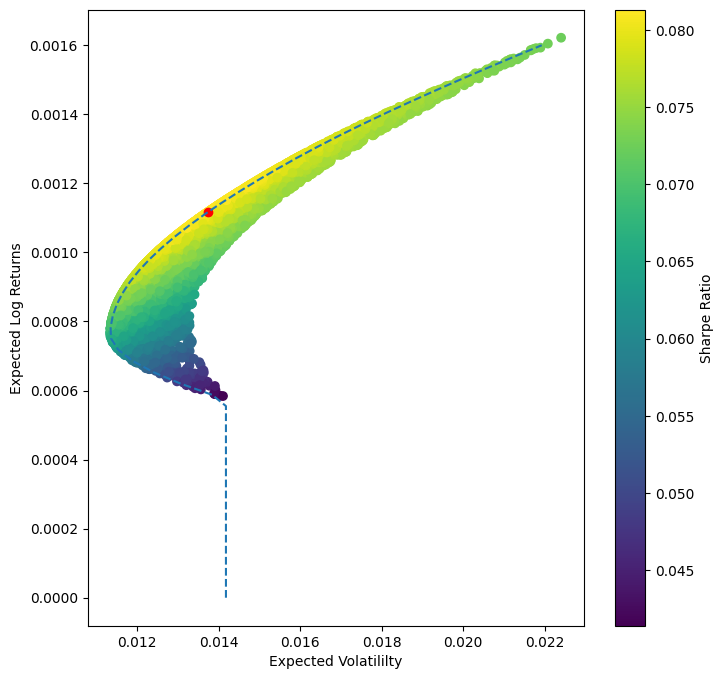

In [ ]:
plotReturnVsVolatility(stock_selected, weight, log_returns, no_of_portfolios)